In [2]:
import sys, os
sys.path.append('..')
import bioGRID as bg
import STRING
import IntAct
import HuRI
import random as rn
import onPPILinkPred as ppiLPred
import numpy as np
import json
from itertools import combinations
from matplotlib import pyplot as plt
from statistics import mean
from statistics import median
import traversalHelper as tr
import pandas as pd
from collections import defaultdict
import matplotlib.gridspec as gridspec
import math
from matplotlib.ticker import NullFormatter
from scipy.signal import savgol_filter
import MINT
import helper as hr
from scipy.interpolate import interp1d
import seaborn as sns

# Data Generating

data to generate: sampled Human PPI dataset (bioGRID & STRING & HuRI, MINT), 50% sampled, 10 samples

In [39]:
# DataFrame standard: {nodeA, nodeB, type, score}
bioGRID_GGI, bioGRID_PPI = bg.parse_bioGRID(filename='./data/BioGRID/BIOGRID-ORGANISM-Homo_sapiens-3.5.187.tab2.txt'
    , wFile_GGI='./data/parsed/BioGRID_homo_GGI.pkl', wFile_PPI='./data/parsed/BioGRID_homo_PPI.pkl', root="../")

sampleFName, sampleBase = ['bioGRID'], [bioGRID_PPI]
for i in range(len(sampleFName)):
    ppi = [list(arr) for arr in np.asarray(sampleBase[i][['nodeA', 'nodeB']])]
    sampledPPIs = [rn.sample(ppi, int(len(ppi)*0.5)) for i in range(10)]
    with open("./genData/{}_homo_sampledPPIs.json".format(sampleFName[i]), "w") as f:
        f.write(json.dumps(sampledPPIs))

In [40]:
# DataFrame standard: {nodeA, nodeB, type, score}
MINT_GGI, MINT_PPI = MINT.parse_MINT(ppiFile='./data/MINT/species human', uniProtMap="./data/UniProt/uniprot-taxonomy_9606.tab", 
                wFile_GGI='./data/parsed/MINT_homo_GGI.pkl', wFile_PPI='./data/parsed/MINT_homo_PPI.pkl', root="../")

sampleFName, sampleBase = ['MINT'], [MINT_PPI]
for i in range(len(sampleFName)):
    ppi = [list(arr) for arr in np.asarray(sampleBase[i][['nodeA', 'nodeB']])]
    sampledPPIs = [rn.sample(ppi, int(len(ppi)*0.5)) for i in range(10)]
    with open("./genData/{}_homo_sampledPPIs.json".format(sampleFName[i]), "w") as f:
        f.write(json.dumps(sampledPPIs))

In [41]:
# DataFrame standard: {nodeA, nodeB, type, score}
STRING_GGI, STRING_PPI = STRING.parse_STRING(ppiFile='./data/STRING/9606.protein.links.v11.0.txt'
    , typeFile='./data/STRING/9606.protein.actions.v11.0.txt'
    , uniProtMap='./data/UniProt/uniprot-taxonomy_9606_STRING.tab', root='../'
    , wFile_GGI='./data/parsed/STRING_homo_GGI.pkl', wFile_PPI='./data/parsed/STRING_homo_PPI.pkl')

sampleFName, sampleBase = ['STRING'], [STRING_PPI]
for i in range(len(sampleFName)):
    ppi = [list(arr) for arr in np.asarray(sampleBase[i][['nodeA', 'nodeB']])]
    sampledPPIs = [rn.sample(ppi, int(len(ppi)*0.5)) for i in range(10)]
    with open("./genData/{}_homo_sampledPPIs.json".format(sampleFName[i]), "w") as f:
        f.write(json.dumps(sampledPPIs))

In [38]:
# DataFrame standard: {nodeA, nodeB, type, score}
HuRI_PPI = HuRI.parse_HuRI(root="../")

sampleFName, sampleBase = ['HuRI'], [HuRI_PPI]
for i in range(len(sampleFName)):
    ppi = [list(arr) for arr in np.asarray(sampleBase[i][['nodeA', 'nodeB']])]
    sampledPPIs = [rn.sample(ppi, int(len(ppi)*0.5)) for i in range(10)]
    with open("./genData/{}_sampledPPIs.json".format(sampleFName[i]), "w") as f:
        f.write(json.dumps(sampledPPIs))

# Data Crunching

see dataGen_Human.py, since running in jupyter notebook may have errors

# Read Data

In [32]:
predPPIs = {}
with open('./resultData/homo/trimmed_predPPIs_homo.json', 'r') as f:
    for line in f.readlines(): predPPIs.update(json.loads(line))
print(list(predPPIs.keys()))

['commonNeighbor_tenTrial_HuRI', 'L3uvJoin_tenTrial_HuRI', 'xyContrib_dualCN_uvJoin_tenTrial_HuRI', 'CRA_tenTrial_HuRI', 'Sim_tenTrial_HuRI', 'CH2_L3_tenTrial_HuRI', 'commonNeighbor_tenTrial_MINT_homo', 'L3uvJoin_tenTrial_MINT_homo', 'xyContrib_dualCN_uvJoin_tenTrial_MINT_homo', 'CRA_tenTrial_MINT_homo', 'Sim_tenTrial_MINT_homo', 'CH2_L3_tenTrial_MINT_homo', 'CH2_L3_tenTrial_STRING_homo', 'commonNeighbor_tenTrial_STRING_homo', 'CRA_tenTrial_STRING_homo', 'xyContrib_dualCN_uvJoin_tenTrial_STRING_homo', 'L3uvJoin_tenTrial_STRING_homo', 'Sim_tenTrial_STRING_homo', 'commonNeighbor_tenTrial_bioGRID_homo', 'CRA_tenTrial_bioGRID_homo', 'xyContrib_dualCN_uvJoin_tenTrial_bioGRID_homo', 'Sim_tenTrial_bioGRID_homo', 'CH2_L3_tenTrial_bioGRID_homo', 'L3uvJoin_tenTrial_bioGRID_homo']


In [19]:
# samplePPI
bg_samplePPIs, STRING_samplePPIs, MINT_samplePPIs, HuRI_samplePPIs = [], [], [], []
with open('./genData/bioGRID_homo_sampledPPIs.json', 'r') as f:
    bg_samplePPIs = json.loads(f.read())
with open('./genData/STRING_homo_sampledPPIs.json', 'r') as f:
    STRING_samplePPIs = json.loads(f.read())
with open('./genData/HuRI_sampledPPIs.json', 'r') as f:
    HuRI_samplePPIs = json.loads(f.read())
with open('./genData/MINT_homo_sampledPPIs.json', 'r') as f:
    MINT_samplePPIs = json.loads(f.read())
bg_samplePPIr, STRING_samplePPIr, HuRI_samplePPIr, MINT_samplePPIr = [], [], [], []
for ppis in bg_samplePPIs: bg_samplePPIr.append(tr.Helper.binary_to_relation(tr.Helper.to_dual_binary_relation(ppis), rSet=True))
for ppis in STRING_samplePPIs: STRING_samplePPIr.append(tr.Helper.binary_to_relation(tr.Helper.to_dual_binary_relation(ppis), rSet=True))
for ppis in MINT_samplePPIs: MINT_samplePPIr.append(tr.Helper.binary_to_relation(tr.Helper.to_dual_binary_relation(ppis), rSet=True))
for ppis in HuRI_samplePPIs: HuRI_samplePPIr.append(tr.Helper.binary_to_relation(tr.Helper.to_dual_binary_relation(ppis), rSet=True))
print(bg_samplePPIs[0][0:5], len(bg_samplePPIs))
print(STRING_samplePPIs[0][0:5], len(STRING_samplePPIs))

[['COPS8', 'COPS4'], ['HSPB2', 'TRAF6'], ['LATS2', 'CCP110'], ['XPO1', 'FBXW5'], ['RNF11', 'GTF2H4']] 10
[['MED12L', 'MED16'], ['ALDH8A1', 'HADH'], ['DDX50', 'NSUN6'], ['CIT', 'RASL10A'], ['CELA2A', 'CTRC']] 10


In [8]:
precRecMap = {}
with open('./resultData/PRCurveMap_homo.json', 'r') as f: precRecMap = json.loads(f.read())
print(list(precRecMap.keys()))

['commonNeighbor_tenTrial_HuRI_0', 'L3uvJoin_tenTrial_HuRI_3', 'xyContrib_dualCN_uvJoin_tenTrial_HuRI_6', 'CRA_tenTrial_HuRI_9', 'CH2_L3_tenTrial_HuRI_2', 'commonNeighbor_tenTrial_HuRI_1', 'L3uvJoin_tenTrial_HuRI_4', 'xyContrib_dualCN_uvJoin_tenTrial_HuRI_7', 'Sim_tenTrial_HuRI_0', 'CH2_L3_tenTrial_HuRI_3', 'commonNeighbor_tenTrial_HuRI_2', 'L3uvJoin_tenTrial_HuRI_5', 'xyContrib_dualCN_uvJoin_tenTrial_HuRI_8', 'Sim_tenTrial_HuRI_1', 'CH2_L3_tenTrial_HuRI_4', 'commonNeighbor_tenTrial_HuRI_3', 'L3uvJoin_tenTrial_HuRI_6', 'xyContrib_dualCN_uvJoin_tenTrial_HuRI_9', 'Sim_tenTrial_HuRI_2', 'CH2_L3_tenTrial_HuRI_5', 'commonNeighbor_tenTrial_HuRI_4', 'L3uvJoin_tenTrial_HuRI_7', 'CRA_tenTrial_HuRI_0', 'Sim_tenTrial_HuRI_3', 'CH2_L3_tenTrial_HuRI_6', 'commonNeighbor_tenTrial_HuRI_5', 'L3uvJoin_tenTrial_HuRI_8', 'CRA_tenTrial_HuRI_1', 'Sim_tenTrial_HuRI_4', 'CH2_L3_tenTrial_HuRI_7', 'commonNeighbor_tenTrial_HuRI_6', 'L3uvJoin_tenTrial_HuRI_9', 'CRA_tenTrial_HuRI_2', 'Sim_tenTrial_HuRI_5', 'CH2_L3

In [35]:
GOScores, GOPPI = {}, {}
with open('./GOSemSimFinalizedData/GOScore_homo.json', 'r') as f: GOScores = json.loads(f.read())
with open('./GOSemSimFinalizedData/GOPPI_homo.json', 'r') as f: GOPPI = json.loads(f.read())
print(list(GOScores.keys()))

['commonNeighbor_tenTrial_MINT_homo', 'L3uvJoin_tenTrial_MINT_homo', 'xyContrib_dualCN_uvJoin_tenTrial_MINT_homo', 'CRA_tenTrial_MINT_homo', 'CH2_L3_tenTrial_MINT_homo', 'Sim_tenTrial_MINT_homo', 'commonNeighbor_tenTrial_STRING_homo', 'L3uvJoin_tenTrial_STRING_homo', 'xyContrib_dualCN_uvJoin_tenTrial_STRING_homo', 'CRA_tenTrial_STRING_homo', 'CH2_L3_tenTrial_STRING_homo', 'Sim_tenTrial_STRING_homo', 'commonNeighbor_tenTrial_HuRI', 'L3uvJoin_tenTrial_HuRI', 'xyContrib_dualCN_uvJoin_tenTrial_HuRI', 'CRA_tenTrial_HuRI', 'CH2_L3_tenTrial_HuRI', 'Sim_tenTrial_HuRI', 'commonNeighbor_tenTrial_bioGRID_homo', 'xyContrib_dualCN_uvJoin_tenTrial_bioGRID_homo', 'CRA_tenTrial_bioGRID_homo', 'Sim_tenTrial_bioGRID_homo', 'CH2_L3_tenTrial_bioGRID_homo', 'L3uvJoin_tenTrial_bioGRID_homo']


In [11]:
# check data
predPPIsK = list(predPPIs.keys())[0]
GOScoresK = list(GOScores.keys())[0]
print(len(predPPIs[predPPIsK][0]), len(GOScores[GOScoresK][0]))

83665 16573


In [16]:
essGenes, essGenesFromPPI = [], []
with open('./../data/parsed/essGene_homo.json', 'r') as f: essGenes = json.loads(f.read())
print(len(essGenes), essGenes[0:5])
essGenes = set(essGenes)

3194 ['FMNL1', 'PIK3CA', 'CIZ1', 'PDS5A', 'SEMA4D']


# Data Properties

In [9]:
# dataset edges
bioGRID_GGI_df, bioGRID_PPI_df = bg.parse_bioGRID(filename='./data/BioGRID/BIOGRID-ORGANISM-Homo_sapiens-3.5.187.tab2.txt'
    , wFile_GGI='./data/parsed/BioGRID_homo_GGI.pkl', wFile_PPI='./data/parsed/BioGRID_homo_PPI.pkl', root="../")
STRING_GGI_df, STRING_PPI_df = STRING.parse_STRING(ppiFile='./data/STRING/9606.protein.links.v11.0.txt'
    , typeFile='./data/STRING/9606.protein.actions.v11.0.txt'
    , uniProtMap='./data/UniProt/uniprot-taxonomy_9606_STRING.tab', root='../'
    , wFile_GGI='./data/parsed/STRING_homo_GGI.pkl', wFile_PPI='./data/parsed/STRING_homo_PPI.pkl')
HuRI_PPI_df = HuRI.parse_HuRI(root='../')
MINT_GGI_df, MINT_PPI_df = MINT.parse_MINT(ppiFile='./data/MINT/species human', uniProtMap="./data/UniProt/uniprot-taxonomy_9606.tab", 
                wFile_GGI='./data/parsed/MINT_homo_GGI.pkl', wFile_PPI='./data/parsed/MINT_homo_PPI.pkl', root="../")
print('PPI size, STRING: {}, bioGRID: {}, HuRI: {}, MINT: {}'.format(
    len(STRING_PPI_df.index), len(bioGRID_PPI_df.index), len(HuRI_PPI_df.index), len(MINT_PPI_df.index)))

print('non-PPI size, STRING: {}, bioGRID: {}, MINT: {}'.format(
    len(STRING_GGI_df.index), len(bioGRID_GGI_df.index), len(MINT_GGI_df.index)))

bioGRID_nodes = tr.Helper.binary_relation_to_node(bioGRID_PPI_df[['nodeA', 'nodeB']].values.tolist())
STRING_nodes = tr.Helper.binary_relation_to_node(STRING_PPI_df[['nodeA', 'nodeB']].values.tolist())
HuRI_nodes = tr.Helper.binary_relation_to_node(HuRI_PPI_df[['nodeA', 'nodeB']].values.tolist())
MINT_nodes = tr.Helper.binary_relation_to_node(MINT_PPI_df[['nodeA', 'nodeB']].values.tolist())
print('# of nodes, bioGRID: {}, STRING: {}, HuRI: {}, MINT: {}'.format(
    len(bioGRID_nodes), len(STRING_nodes), len(HuRI_nodes), len(MINT_nodes)))

# selected top edges
trimNum = {'bioGRID': int(len(bioGRID_PPI_df.index)*0.5)
        , 'STRING': int(len(STRING_PPI_df.index)*0.5)
        , 'HuRI': int(len(HuRI_PPI_df.index)*0.5)
        , 'MINT': int(len(MINT_PPI_df.index)*0.5)}
print("top n edges: bioGRID: {}, STRING: {}, HuRI: {}, MINT: {}".format(
  trimNum['bioGRID'], trimNum['STRING'], trimNum['HuRI'], trimNum['MINT']))

PPI size, STRING: 122827, bioGRID: 604747, HuRI: 167331, MINT: 33146
non-PPI size, STRING: 397978, bioGRID: 9121, MINT: 1880
# of nodes, bioGRID: 24381, STRING: 13712, HuRI: 8135, MINT: 7430
top n edges: bioGRID: 302373, STRING: 61413, HuRI: 83665, MINT: 16573


In [12]:
datasets = ['STRING_homo', 'bioGRID_homo', 'MINT_homo', 'HuRI']
for dataset in datasets:
    amongTrials = []
    for i in range(10):
        amongCores = []
        for j in range(24):
            file = './resultData/homo/candidateSz/tenTrial_{}_{}_c{}_candidateNum.txt'.format(dataset, i, j)
            with open(file, 'r') as f: amongCores.append(int(f.read()))
        amongTrials.append(sum(amongCores))
    print("dataset {}, mean count {}".format(dataset, mean(amongTrials)))

dataset STRING_homo, mean count 74147866.4
dataset bioGRID_homo, mean count 224868220.7
dataset MINT_homo, mean count 17396746.3
dataset HuRI, mean count 30904949.3


In [10]:
# runTime
fName = './resultData/homo/runTime.json'
runTimeD = {}
with open(fName, 'r') as f: runTimeD = json.loads(f.read())
    
tags = ["commonNeighbor", "L3uvJoin", "xyContrib_dualCN_uvJoin", "CRA", 'CH2_L3', 'Sim']
datasets = ["STRING_homo", "bioGRID_homo"]
for dataset in datasets:
    for tag in tags:
        secs = []
        dName = "{}_tenTrial_{}_{}".format(tag, dataset, 0)
        secs.append(runTimeD[dName])
        avgSec = mean(secs)
        print("algor {}, dataset {}, avg min {}m".format(tag, dataset, avgSec/60))
    print("\n")

algor commonNeighbor, dataset STRING_homo, avg min 0.2287102500597636m
algor L3uvJoin, dataset STRING_homo, avg min 0.9367050051689148m
algor xyContrib_dualCN_uvJoin, dataset STRING_homo, avg min 1.5092555125554403m
algor CRA, dataset STRING_homo, avg min 0.24199925263722738m
algor CH2_L3, dataset STRING_homo, avg min 1.3117433786392212m
algor Sim, dataset STRING_homo, avg min 1.0877801299095153m


algor commonNeighbor, dataset bioGRID_homo, avg min 0.9167550881703694m
algor L3uvJoin, dataset bioGRID_homo, avg min 17.82512502670288m
algor xyContrib_dualCN_uvJoin, dataset bioGRID_homo, avg min 104.95484203894934m
algor CRA, dataset bioGRID_homo, avg min 0.9774058580398559m
algor CH2_L3, dataset bioGRID_homo, avg min 154.7483209133148m
algor Sim, dataset bioGRID_homo, avg min 46.16369481484095m




In [ ]:
labels = {
    "commonNeighbor_tenTrial_": "CN",
    "L3uvJoin_tenTrial_": "L3",
    "L3Raw_tenTrial_": "L3Raw",
    "CRA_tenTrial_": "CRA",
    "CH2_L3_tenTrial_": "CH2",
    "Sim_tenTrial_": "Sim",
    "xyContrib_dualCN_uvJoin_tenTrial_": "L3E",
    "uvSpec_xySpec_xyContrib_uvJoin_tenTrial_": "ExactL3B"
}
colors = {
    "commonNeighbor_tenTrial_": "red",
    "L3uvJoin_tenTrial_": "darkorange",
    "CRA_tenTrial_": "fuchsia",
    "CH2_L3_tenTrial_": "grey",
    "Sim_tenTrial_": "green",
    "xyContrib_dualCN_uvJoin_tenTrial_": "dodgerblue",
    "uvSpec_xySpec_xyContrib_uvJoin_tenTrial_": "darkorchid"
}

# Stats Significance

In [ ]:
def precRecPlot_multiLine(precsList, recsList, decimalPt, xTtickInterval, yTickInterval, legends, figsize=(30,30), font=20):
    interval = 1/(10**decimalPt)
    decimalPt = str(decimalPt)
    tmp = []
    corrStr = "{0:."+decimalPt+"f}"
    for precs in precsList: tmp.append([float(corrStr.format(prec)) for prec in precs])
    precsList = tmp.copy()
    tmp = []
    for recs in recsList: tmp.append([float(corrStr.format(rec)) for rec in recs])
    recsList = tmp.copy()
    fig = plt.figure(figsize=figsize)
    plt.rc('font', size=font)
    
    maxRec, maxPrec = max(np.asarray(recsList).flatten()), max(np.asarray(precsList).flatten())
    xTicks, yTicks = [i*xTtickInterval for i in range(0, int((maxRec+xTtickInterval)/xTtickInterval))], [i*yTickInterval for i in range(0, int((maxPrec+yTickInterval)/yTickInterval))]
    plt.xticks(xTicks)
    plt.yticks(yTicks)
    
    for i in range(0, len(precsList)):
        plt.plot(recsList[i], precsList[i], label=legends[i])
    plt.legend()
    ax = plt.gca()
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.grid(axis='y')
    return fig
"precRecPlot function"

In [ ]:
def distance_scoring(mainLine, otherLines):
    # mainLine = [a,b,c,...,x,y,z]
    # otherLines = [[a,b,c,...,x,y,z], [a,b,c,...,x,y,z]]
    otherLines = [otherLine+[0]*(len(mainLine)-len(otherLine)) if len(mainLine) > len(otherLine) else otherLine[:len(mainLine)] for otherLine in otherLines]
    score = 0
    for i in range(len(mainLine)):
        score += sum([mainLine[i]-otherLine[i] for otherLine in otherLines])
    return score

In [ ]:
def manual_transpose(arrs):
    inverted = []
    print([len(arr) for arr in arrs])
    for i in range(len(arrs[0])):
        inverted.append([arr[i] for arr in arrs])
    return inverted

In [ ]:
def get_plots_outline(plots, boundFunc):
    # func can be: min, max, avg, median
    invertedArr = np.transpose(np.asarray(plots))
    boundPlot = [boundFunc(arr) for arr in invertedArr]
    return boundPlot

In [ ]:
def standardize_plots(precsList, recsList, decimalPt):
    # note that the rec is trimmed in favor of the smallest rec (both min max)
    # corr recList to decimal pt -> create a rec list with minimum unit interval
    # -> map prec of each list to the rec list position, dont exists then np.nan -> use pandas interpolate
    corrStr = "{0:."+str(decimalPt)+"f}"
    tmp = []
    for recs in recsList: tmp.append(np.asarray([float(corrStr.format(rec)) for rec in recs]))
    recsList = tmp.copy()
    flattenRecs = np.asarray(recsList).flatten()
    minBoundRec, maxBoundRec = max([recs[0] for recs in recsList]), min([recs[-1] for recs in recsList])
    baseRecs = np.asarray([i for i in range(int(minBoundRec*(10**decimalPt)), int(maxBoundRec*(10**decimalPt)))])/10**decimalPt
    alignedPrecsList = []
    for i in range(len(precsList)):
        precsMap = {}
        for k in baseRecs: precsMap[k] = np.nan
        for j in range(len(precsList[i])):
            if recsList[i][j] in precsMap: precsMap[recsList[i][j]] = precsList[i][j]
        mappedPrecs = pd.Series(list(precsMap.values()))
        alignedPrecsList.append(list(np.asarray(mappedPrecs.interpolate())))
    return alignedPrecsList, baseRecs

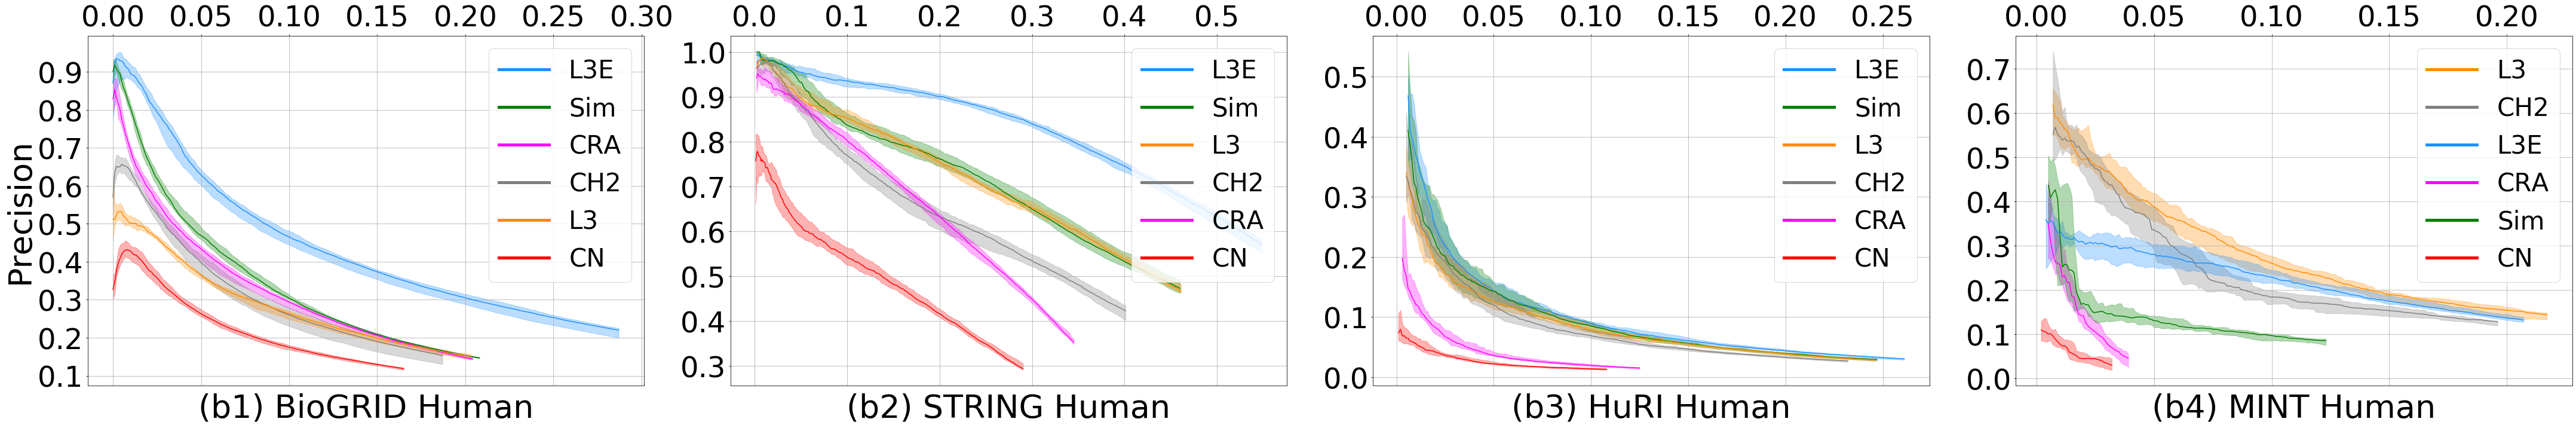

In [9]:
fNamesList = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'CRA_tenTrial_', 'CH2_L3_tenTrial_', 'Sim_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_']

fNamesTitle = ['(b1) BioGRID Human', '(b2) STRING Human', '(b3) HuRI Human', '(b4) MINT Human']
plt.rc('axes', titlesize=54)
plt.rc('axes', labelsize=54)
plt.rc('xtick', labelsize=48)
plt.rc('ytick', labelsize=48)
plt.rc('legend', fontsize=42) 
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
fig, axes = plt.subplots(1, 4, figsize=(60,10))
xIntervals, yIntervals = [0.05, 0.1, 0.05, 0.05], [0.1, 0.1, 0.1, 0.1]
datasets = ['bioGRID_homo', 'STRING_homo', 'HuRI', 'MINT_homo']
for j in range(len(datasets)):
    dataset = datasets[j]
    fNames = [i+dataset for i in fNamesList]
    #tags = ['_'.join(fName.split('_')[:-2]) for fName in fNames]
    slideRange = (100, len(precRecMap[fNames[0]+"_0"]["prec"]))
    precsList = [[precRecMap[fName+"_{}".format(i)]["prec"][slideRange[0]:slideRange[1]] for i in range(10)] for fName in fNames]
    recsList = [[precRecMap[fName+"_{}".format(i)]["rec"][slideRange[0]:slideRange[1]] for i in range(10)] for fName in fNames]
    xInterval, yInterval = xIntervals[j], yIntervals[j]
    axes[j].set_xticks([i*xInterval for i in range(0, int((1+xInterval)/xInterval))])
    axes[j].set_yticks([i*yInterval for i in range(0, int((1+yInterval)/yInterval))])

    # sort the fName by curve bounding
    precCurves = {}
    for i in range(len(fNames)):
        prec, rec = precsList[i], recsList[i]
        alignedPrecs, baseRec = standardize_plots(prec, rec, 3)
        upperPrec, lowerPrec, avgPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
        precCurves[fNames[i]] = avgPrec
    
    precScores = {}
    for i in precCurves:
        precScores[i] = distance_scoring(precCurves[i], [precCurves[k] for k in precCurves if k != i])
    fNames, sVals = hr.sort_key_val(list(precScores.keys()), list(precScores.values()))
    
    # using the curve bounding to sort the legend
    for i in range(len(fNames)):      
        slideRange = (100, len(precRecMap[fNames[0]+"_0"]["prec"]))
        prec = [precRecMap[fNames[i]+"_{}".format(n)]["prec"][slideRange[0]:slideRange[1]] for n in range(10)]
        rec = [precRecMap[fNames[i]+"_{}".format(n)]["rec"][slideRange[0]:slideRange[1]] for n in range(10)]

        
        alignedPrecs, baseRec = standardize_plots(prec, rec, 3)
        upperPrec, lowerPrec, avgPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
        
        if "homo" in dataset: tag = labels["_".join(fNames[i].split("_")[:-2])+"_"]
        else: tag = labels["_".join(fNames[i].split("_")[:-1])+"_"]
        if "homo" in dataset: color = colors["_".join(fNames[i].split("_")[:-2])+"_"]
        else: color = colors["_".join(fNames[i].split("_")[:-1])+"_"]
        
        axes[j].fill_between(baseRec, lowerPrec, upperPrec, facecolor=color, color=color, alpha=0.3)        
        axes[j].plot(baseRec, avgPrec, color=color, label=tag)
    # axes[j].set_xlabel("Recall")
    axes[j].grid()
    axes[j].set_title(fNamesTitle[j], y=-0.1)
    leg = axes[j].legend()
    for line in leg.get_lines():
        line.set_linewidth(5.0)
        
axes[0].set_ylabel("Precision")
plt.tight_layout()
plt.savefig('./img/PRCurve_homo_BIBE.png')
plt.show()
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

# Bio Significance

In [33]:
# top all, window 100, sliding 10, STRING
fNames = ['commonNeighbor_tenTrial_STRING', 'L3uvJoin_tenTrial_STRING', 'xyContrib_dualCN_uvJoin_tenTrial_STRING', 'CRA_tenTrial_STRING', 'CH2_L3_tenTrial_STRING', 'Sim_tenTrial_STRING']
fNames = [i+"_homo" for i in fNames]
tags = ['_'.join(fName.split('_')[:-2]) for fName in fNames]

_, STRING_df = STRING.parse_STRING(ppiFile='./data/STRING/9606.protein.links.v11.0.txt'
    , typeFile='./data/STRING/9606.protein.actions.v11.0.txt'
    , uniProtMap='./data/UniProt/uniprot-taxonomy_9606_STRING.tab', root='../'
    , wFile_GGI='./data/parsed/STRING_homo_GGI.pkl', wFile_PPI='./data/parsed/STRING_homo_PPI.pkl')

STRING_PPI = [tr.Helper.br_to_pathStr(list(ppi)) for ppi in np.asarray(STRING_df[['nodeA', 'nodeB']])]
STRING_PPI += [tr.Helper.br_to_pathStr(list(ppi)[::-1]) for ppi in np.asarray(STRING_df[['nodeA', 'nodeB']])]
STRING_Score = list(np.asarray(STRING_df['score']))+list(np.asarray(STRING_df['score']))
STRING_scoreMap = dict(zip(STRING_PPI, STRING_Score))

window, slidingFrame = 100, 10
ppiMMScoresList = defaultdict(list)
for fName in fNames: # 4 algorithms
    predPPI = np.asarray([tr.Helper.list_to_pathStrs(PPIs) for PPIs in predPPIs[fName]])
    for ppiArr in predPPI: # 10 trials
        ppiMMScoresList[fName].append([])
        for i in range(0, len(ppiArr)-window, slidingFrame):
            ppiCluster = ppiArr[i:i+window]
            scores = [STRING_scoreMap[ppiStr] if ppiStr in STRING_scoreMap else 0 for ppiStr in ppiCluster]
            if len(scores) > 0: ppiMMScoresList[fName][-1].append(mean(scores))
            else: ppiMMScoresList[fName][-1].append(0)

In [36]:
bioGRID_GGI_df, bioGRID_PPI_df = bg.parse_bioGRID(filename='./data/BioGRID/BIOGRID-ORGANISM-Homo_sapiens-3.5.187.tab2.txt'
    , wFile_GGI='./data/parsed/BioGRID_homo_GGI.pkl', wFile_PPI='./data/parsed/BioGRID_homo_PPI.pkl', root="../")
STRING_GGI_df, STRING_PPI_df = STRING.parse_STRING(ppiFile='./data/STRING/9606.protein.links.v11.0.txt'
    , typeFile='./data/STRING/9606.protein.actions.v11.0.txt'
    , uniProtMap='./data/UniProt/uniprot-taxonomy_9606_STRING.tab', root='../'
    , wFile_GGI='./data/parsed/STRING_homo_GGI.pkl', wFile_PPI='./data/parsed/STRING_homo_PPI.pkl')
HuRI_PPI_df = HuRI.parse_HuRI(root='../')
MINT_GGI_df, MINT_PPI_df = MINT.parse_MINT(ppiFile='./data/MINT/species human', uniProtMap="./data/UniProt/uniprot-taxonomy_9606.tab", 
                wFile_GGI='./data/parsed/MINT_homo_GGI.pkl', wFile_PPI='./data/parsed/MINT_homo_PPI.pkl', root="../")
trimNum = {'bioGRID_homo': int(len(bioGRID_PPI_df.index)*0.5)
        , 'STRING_homo': int(len(STRING_PPI_df.index)*0.5)
        , 'HuRI': int(len(HuRI_PPI_df.index)*0.5)
        , 'MINT_homo': int(len(MINT_PPI_df.index)*0.5)}


tags = ['commonNeighbor', 'L3uvJoin', 'xyContrib_dualCN_uvJoin', 'CRA', 'Sim', 'CH2_L3']
#datasets = ['bioGRID_homo', 'STRING_homo', 'HuRI', 'MINT_homo']
datasets = ['bioGRID_homo', 'STRING_homo', 'HuRI', 'MINT_homo']
AvgGOScores, stdGOScores, GOScores_trim = {}, {}, {}
for k in range(len(datasets)):
    for tag in tags:
        flattenGO = []
        tag = '{}_tenTrial_{}'.format(tag, datasets[k])
        GOScores_trim[tag] = [j[:int(trimNum[datasets[k]]*0.1)] for j in GOScores[tag]]
        AvgGOScores[tag] = [mean(j) for j in np.transpose(np.asarray(GOScores_trim[tag]))]
        stdGOScores[tag] = np.std(AvgGOScores[tag])

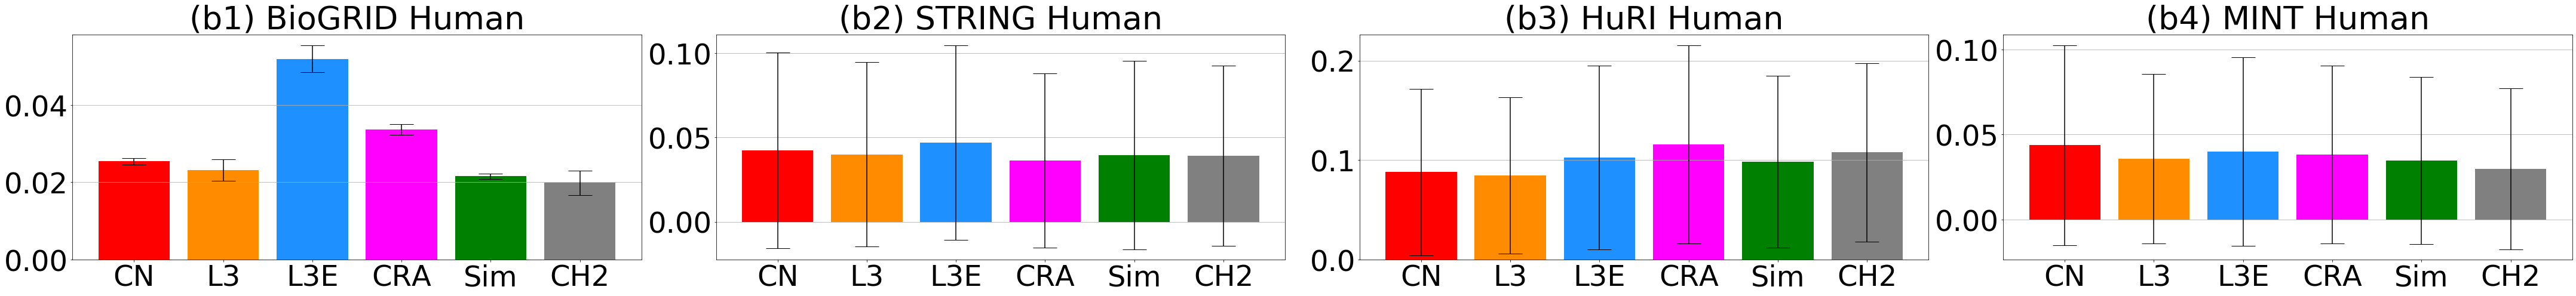

In [38]:
tags = ['commonNeighbor', 'L3uvJoin', 'xyContrib_dualCN_uvJoin', 'CRA', 'Sim', 'CH2_L3']
datasets = ['bioGRID_homo', 'STRING_homo', 'HuRI', 'MINT_homo']
titles = ['(b1) BioGRID Human', '(b2) STRING Human', '(b3) HuRI Human', '(b4) MINT Human']
plt.rc('axes', titlesize=54)
plt.rc('axes', labelsize=54)
plt.rc('xtick', labelsize=48) 
plt.rc('ytick', labelsize=48) 
plt.rc('legend', fontsize=48)
fig, axes = plt.subplots(1,4,figsize=(60,7))
for k in range(len(datasets)):
    axes[k].bar([labels[tag+"_tenTrial_"] for tag in tags], [mean(AvgGOScores[tag+"_tenTrial_"+datasets[k]]) for tag in tags]
                , color=[colors[tag+"_tenTrial_"] for tag in tags], yerr=[stdGOScores[tag+"_tenTrial_"+datasets[k]] for tag in tags]
                , capsize=20)
    axes[k].grid(axis='y')
    #axes[k].set_xlabel('PPI Link Predictors')
    axes[k].set_title(titles[k])
# axes[0].set_ylabel('GOSemSim scores')
plt.tight_layout()
plt.savefig('./img/GOSemSimBar_top1000_BIBE_homo.png')
plt.show()

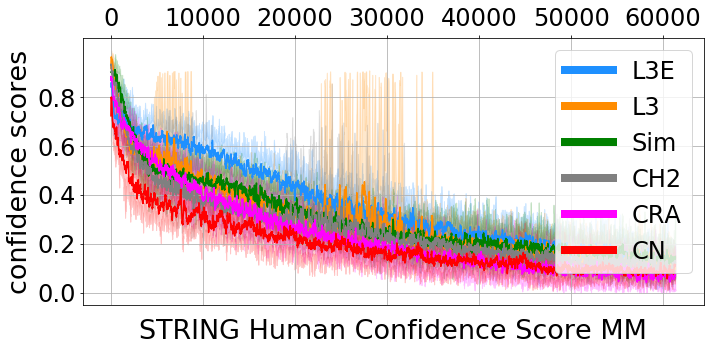

In [34]:
plt.rc('axes', titlesize=27)
plt.rc('axes', labelsize=27)
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24) 
plt.rc('legend', fontsize=24)
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
fig = plt.figure(figsize=(10,5))

fNames = ['commonNeighbor_tenTrial_STRING', 'L3uvJoin_tenTrial_STRING', 'CRA_tenTrial_STRING', 'Sim_tenTrial_STRING', 'CH2_L3_tenTrial_STRING', 'xyContrib_dualCN_uvJoin_tenTrial_STRING']
fNames = [i+"_homo" for i in fNames]
xInterval, yInterval = 10000, 0.2
xList = [(i+1)*10 for i in range(len(ppiMMScoresList[fNames[0]][0]))]
xTicks, yTicks = [i*xInterval for i in range(0, int(len(xList)+xInterval/xInterval))], [i*yInterval for i in range(0, int((1+yInterval)/yInterval))]
plt.xticks(xTicks)
plt.yticks(yTicks)

# sort the fName by curve bounding
precCurves = {}
for i in range(len(fNames)):
    avgScore = get_plots_outline(ppiMMScoresList[fNames[i]], mean)
    precCurves[fNames[i]] = avgScore

precScores = {}
for i in precCurves:
    precScores[i] = distance_scoring(precCurves[i], [precCurves[k] for k in precCurves if k != i])
fNames, sVals = hr.sort_key_val(list(precScores.keys()), list(precScores.values()))


for i in range(len(fNames)):
    upperScore, lowerScore, avgScore = get_plots_outline(ppiMMScoresList[fNames[i]], max), get_plots_outline(ppiMMScoresList[fNames[i]], min), get_plots_outline(ppiMMScoresList[fNames[i]], mean)
    fNames[i] = "_".join(fNames[i].split("_")[:-2])+"_"
    plt.fill_between(xList, lowerScore, upperScore, facecolor=colors[fNames[i]], color=colors[fNames[i]], alpha=0.2)
    plt.plot(xList, avgScore, color=colors[fNames[i]], label=labels[fNames[i]])
ax = plt.gca()
#ax.set_xlabel('Position in Ranked PPIs')
ax.set_ylabel('confidence scores')
#ax.set_title('STRING Confidence Score MM, Human')
ax.grid()
ax.set_title('STRING Human Confidence Score MM', y=-0.15)
leg = plt.legend(loc="upper right")
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.tight_layout()
plt.savefig('./img/confScore_BIBE_homo.png')
plt.show()
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

# Essential Gene Growth Rate

In [17]:
tags = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_', 'CRA_tenTrial_', 'CH2_L3_tenTrial_', 'Sim_tenTrial_']
fNamesList = [tag+dataset for tag in tags for dataset in ['STRING_homo', 'bioGRID_homo', 'MINT_homo', 'HuRI']]
hitNum = {}
for fName in fNamesList:
    currPredPPI = predPPIs[fName]
    hitList = []
    for i in range(0, 10):
        hitList.append([])
        nodeList = set()
        for k in range(0, len(currPredPPI[i])):
            nodeList.update(currPredPPI[i][k])
            hitList[-1].append(len(nodeList&essGenes))
    hitNum[fName] = hitList.copy()
with open('./resultData/homo/hitNumDict.json', 'w') as f:
    f.write(json.dumps(hitNum))

In [22]:
tags = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_', 'CRA_tenTrial_', 'CH2_L3_tenTrial_', 'Sim_tenTrial_']
fNamesList = [tag+dataset for tag in tags for dataset in ['STRING_homo', 'bioGRID_homo', 'MINT_homo', 'HuRI']]
essDegDict = {}
for fName in fNamesList:
    currPredPPI = predPPIs[fName]
    essDegs = []
    if 'bioGRID' in fName: samplePPIr = bg_samplePPIr.copy()
    elif 'STRING' in fName: samplePPIr = STRING_samplePPIr.copy()
    elif 'MINT' in fName: samplePPIr = MINT_samplePPIr.copy()
    elif 'HuRI' in fName: samplePPIr = HuRI_samplePPIr.copy()
    for i in range(0, 10):
        essDegs.append([])
        essNodes = set()
        nodeList = set()
        for k in range(0, len(currPredPPI[i])):
            nodeList.update(currPredPPI[i][k])
            newEss = (nodeList&essGenes)-essNodes
            essNodes.update(newEss)
            essDegs[-1].append([len(samplePPIr[i][node]) for node in newEss])
    essDegDict[fName] = essDegs.copy()
with open('./resultData/homo/essDegDict.json', 'w') as f:
    f.write(json.dumps(essDegDict))

In [24]:
hitNum = {}
with open('./resultData/homo/hitNumDict.json', 'r') as f:
    hitNum = json.loads(f.read())
essDegDict = {}
with open('./resultData/homo/essDegDict.json', 'r') as f:
    essDegDict = json.loads(f.read())

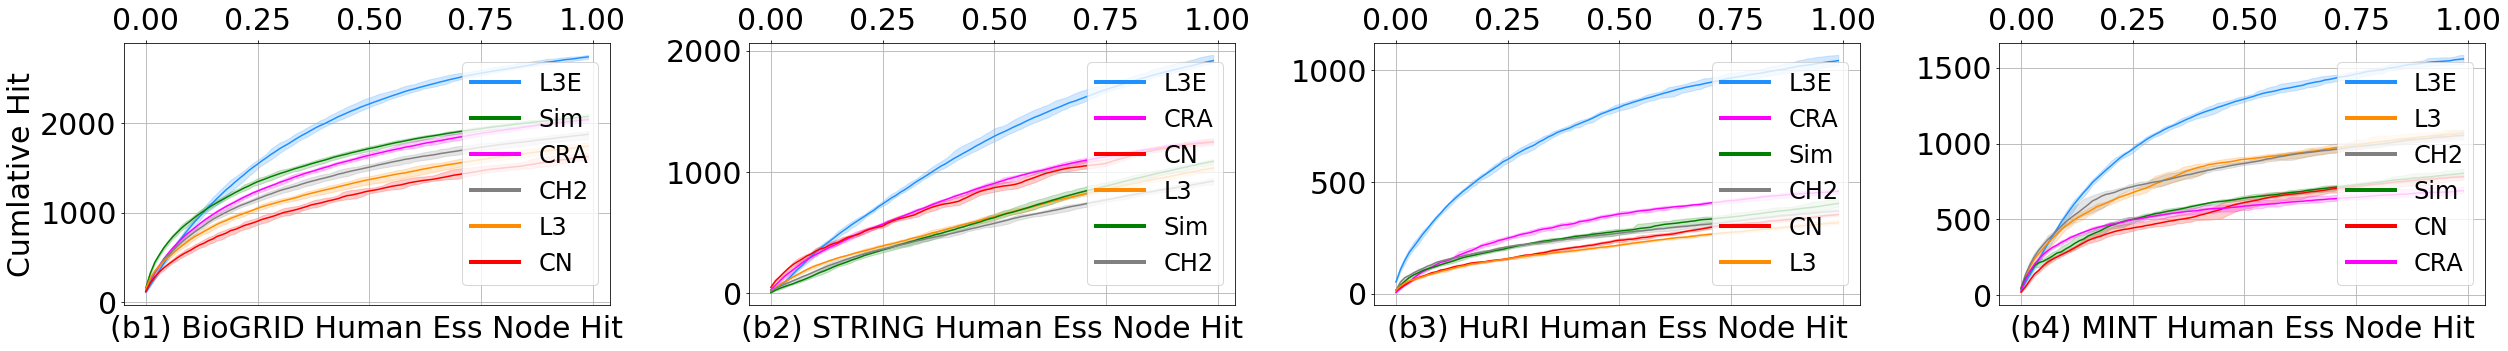

In [28]:
## use essGenes list
fNamesList = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_', 'CRA_tenTrial_', 'CH2_L3_tenTrial_', 'Sim_tenTrial_']
color = ['red', 'darkorange', 'fuchsia', 'green', 'dodgerblue', 'darkorchid', 'grey']
fNamesTitle = ['(b1) BioGRID Human Ess Node Hit', '(b2) STRING Human Ess Node Hit', '(b3) HuRI Human Ess Node Hit', '(b4) MINT Human Ess Node Hit']
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=30)
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.rc('legend', fontsize=24)
fig, axes = plt.subplots(1, 4, figsize=(35,5))
datasets = ['bioGRID_homo', 'STRING_homo', 'HuRI', 'MINT_homo']
for j in range(len(datasets)):
    fNames = [i+datasets[j] for i in fNamesList]

    # sort the fName by curve bounding
    precCurves = {}
    for i in range(len(fNames)):
        hitList = hitNum[fNames[i]]
        xList = [[(k+1)/len(l) for k in range(0, len(l))] for l in hitList]
        alignedHit, baseX = standardize_plots(hitList, xList, 2)
        avgHit = get_plots_outline(alignedHit, mean)
        precCurves[fNames[i]] = avgHit

    precScores = {}
    for i in precCurves:
        precScores[i] = distance_scoring(precCurves[i], [precCurves[k] for k in precCurves if k != i])
    fNames, sVals = hr.sort_key_val(list(precScores.keys()), list(precScores.values()))
    
    if datasets[j] != 'HuRI':
        label = [labels["_".join(i.split("_")[:-2])+"_"] for i in fNames]
        color = [colors["_".join(i.split("_")[:-2])+"_"] for i in fNames]
    else:
        label = [labels["_".join(i.split("_")[:-1])+"_"] for i in fNames]
        color = [colors["_".join(i.split("_")[:-1])+"_"] for i in fNames]
    
    for i in range(len(fNames)):
        hitList = hitNum[fNames[i]]
        xList = [[(k+1)/len(l) for k in range(0, len(l))] for l in hitList]
        alignedHit, baseX = standardize_plots(hitList, xList, 2)
        upperHit, lowerHit, avgHit = get_plots_outline(alignedHit, max), get_plots_outline(alignedHit, min), get_plots_outline(alignedHit, mean)
        axes[j].fill_between(baseX, lowerHit, upperHit, facecolor=color[i], color=color[i], alpha=0.2)
        axes[j].plot(baseX, avgHit, color=color[i], label=label[i])
        axes[j].set_xticks([i/100 for i in range(0,110,25)])
    #axes[j].set_xlabel("Ratio of top n PPIs")
    axes[j].grid()
    #axes[j].set_title(fNamesTitle[j])
    axes[j].set_title(fNamesTitle[j], y=-0.15)
    leg = axes[j].legend(loc='right')
    for line in leg.get_lines():
        line.set_linewidth(4.0)
#axes[3].legend()
axes[0].set_ylabel("Cumlative Hit")
plt.tight_layout()
plt.savefig('./img/essGeneFreq_homo.png')
plt.show()
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

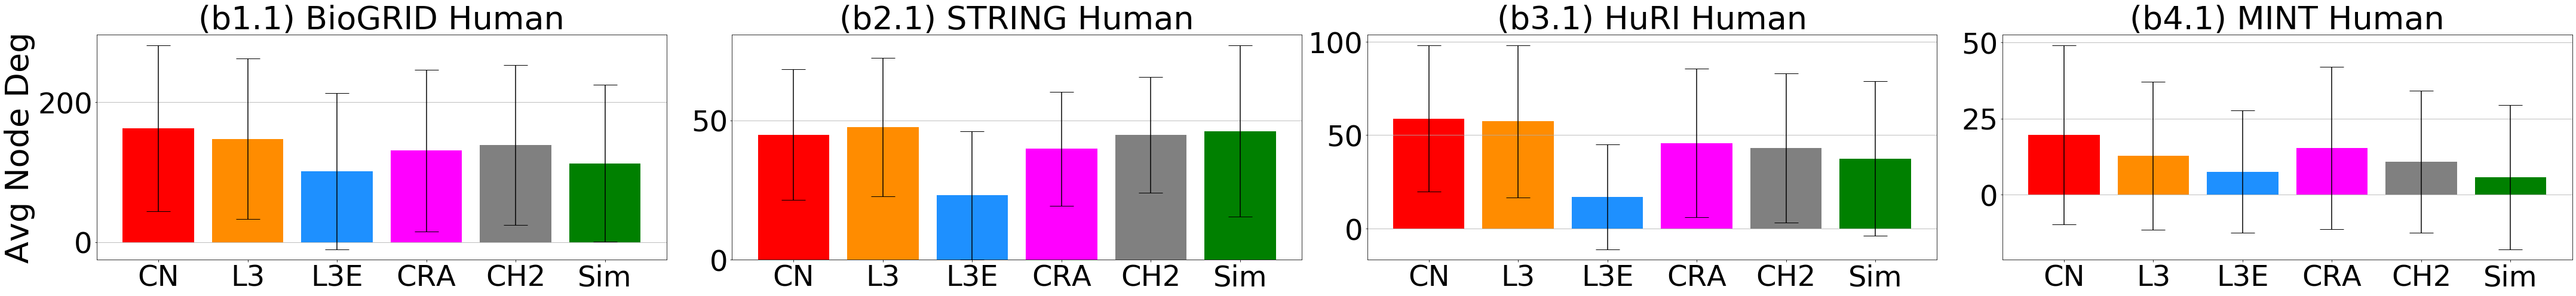

In [30]:
fNamesList = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_', 'CRA_tenTrial_', 'CH2_L3_tenTrial_', 'Sim_tenTrial_']
datasets = ['bioGRID_homo', 'STRING_homo', 'HuRI', 'MINT_homo']
titles = ['(b1.1) BioGRID Human', '(b2.1) STRING Human', '(b3.1) HuRI Human', '(b4.1) MINT Human']
plt.rc('axes', titlesize=54)
plt.rc('axes', labelsize=54)
plt.rc('xtick', labelsize=48) 
plt.rc('ytick', labelsize=48) 
plt.rc('legend', fontsize=48)
fig, axes = plt.subplots(1,4,figsize=(60,7))
topNo = 1000
for k in range(len(datasets)):
    dataset = datasets[k]
    fNames = [i+dataset for i in fNamesList]
    meanEssDeg, stdDeg = [], []
    for i in range(len(fNames)):
        tmp = [a for t in essDegDict[fNames[i]] for a in t[:int(len(t)*0.1)] if len(a) > 0]
        topEssDeg = []
        for t in tmp: topEssDeg += t
        stdDeg.append(np.std(topEssDeg))
        meanEssDeg.append(mean(topEssDeg))
        
    axes[k].bar([labels[tag] for tag in fNamesList], meanEssDeg
                , color=[colors[tag] for tag in fNamesList], yerr=stdDeg
                , capsize=20)
    axes[k].grid(axis='y')
    #axes[k].set_xlabel('PPI Link Predictors')
    axes[k].set_title(titles[k])
axes[0].set_ylabel('Avg Node Deg')
plt.tight_layout()
plt.savefig('./img/EssGeneBar_top1000_BIBE_homo.png')
plt.show()